# Implementing Ke et al. 2018 within python
Notes:
I was able to fully implement Ke et al.'s dynamics. Will try to replicate the heatmap and see how that works out - but the heatmap may actually take a long time. Could be good to search through the parameter space - but good job in implementing the paper's model.

A few things that we would need to do before implementing two different cell populations are:
1. Add the change in virion. That is dependent on the number of activated cells in the system and the decay of the virion. 
    - Don't know what the parameters are but there are some dummy parameters available that I put in. It looks like the graph that Alison had drawn briefly
2. Add a drug decay term. That acts on the alpha term.
    - An issue encountered here is that the assumption is that the drug efficacy parameter is linearly related to the drug combination. I think what a better assumption is steeper, maybe some sort of exponential. 
    - Unsure how to actually make that equation steeper.
3. Convert everything to concentrations that are measurable in the blood. 
    - Attempted to  convert everything to T cells ~ 1000/uL - Will have to play with better parameters. However, it seems to the model seems to be fairly scalable and replicates the results from what would be seen with the 1 million cell number. 
4. Add a second population of cells

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

## Define Model

In [62]:
#Define the model
def model(z,t):
    #Set initial conditions for drugs
    I = z[0]
    B = z[1]
    a = z[2]
    
    #Set initial conditions for Central Memory T cells
    Lc = z[3]
    Ac = z[4]
    Rc = z[5]
    
    #Set initial conditions for Naive T cells
    Ln = z[6]
    An = z[7]
    Rn = z[8]
    
    #Set initial Conditions for Virion produced
    V = z[9]
    
    
    #for drug dosing
    dIdt = -e*I
    dBdt = e*I-k*B
    dadt = dBdt*(1/20)
    
    #for central memory T cells
    dLcdt = (p_c-d_c)*Lc - n_c*Lc - a*Lc + w_c*Rc
    dAcdt = (p_c-delta_c)*Ac + a*Lc - gamma_c*Ac
    dRcdt = (p_c-d_c)*Rc + gamma_c*Ac - w_c*Rc
    
    #for naive T cells
    dLndt = (p_n-d_n)*Ln - n_n*Ln - (1/4)*a*Ln + w_n*Rn
    dAndt = (p_n-delta_n)*An + (1/4)*a*Ln - gamma_n*An
    dRndt = (p_n-d_n)*Rn + gamma_n*An - w_n*Rn
    
    #for both cells
    dVdt = ld_c*Ac + ld_n*An - dv*V
    
    
    dzdt = [dIdt, dBdt, dadt,
            dLcdt, dAcdt, dRcdt, 
            dLndt, dAndt, dRndt, 
            dVdt
            ]
    return dzdt

## Set Initial Conditions and Solve for Those Conditions

In [106]:
#initial conditions, there are three
z0 = [5,0,0,
      9,0,0,
      1,0,0,
      0
     ]

#number of time points
tn = 10001

#time points
t = np.linspace(0,1000, tn)


#store solutions
#Drug Doses
I = np.empty_like(t)
B = np.empty_like(t)
a = np.empty_like(t)

#Tcm cells
Lc = np.empty_like(t)
Ac = np.empty_like(t)
Rc = np.empty_like(t)
Tc = np.empty_like(t)

#Tn cells
Ln = np.empty_like(t)
An = np.empty_like(t)
Rn = np.empty_like(t)
Tn = np.empty_like(t)

#Virion
V = np.empty_like(t)


#record intial

I[0] = z0[0]
B[0] = z0[1]
a[0] = z0[2]

Lc[0] = z0[3]
Ac[0] = z0[4]
Rc[0] = z0[5]

Ln[0] = z0[6]
An[0] = z0[7]
Rn[0] = z0[8]

V[0] = z0[9]

Tc[0] = Lc[0]+Ac[0]+Rc[0]
Tn[0] = Ln[0]+An[0]+Rn[0]

#Constants for Tcm
con = 10**0
d_c = 0.006 * con
n_c = 0.0012#0.0017* con
p_c = 0.0072* con
delta_c = 0.5*con
gamma_c = 0.5*con
w_c = 1
ld_c = 250

#Constants for Tn
d_n = 0.0000009 * con
n_n = 0 #0.005* con
p_n = 0.000002* con
delta_n = 0.1*con
gamma_n = 10*con
w_n = 10
ld_n = 300


#Constants for Viruse
dv = 0.01

#constants for the drugs
k = 0.4
e = 0.5

#Solve the ODE
for i in range(1,tn):
    tspan = [t[i-1],t[i]]
    # solve for next step
    z = odeint(model,z0,tspan)
    # store solution for plotting
        
    I[i] = z[1][0]
    B[i] = z[1][1]
    a[i] = z[1][2]
    
    Lc[i] = z[1][3]
    Ac[i] = z[1][4]
    Rc[i] = z[1][5]

    Ln[i] = z[1][6]
    An[i] = z[1][7]
    Rn[i] = z[1][8]
    
    V[i] = z[1][9]
        
    Tc[i] = Lc[i]+Ac[i]+Rc[i]
    Tn[i] = Ln[i]+An[i]+Rn[i]
    # next initial condition
    z0 = z[1] 



## Plot Data for One Dose 

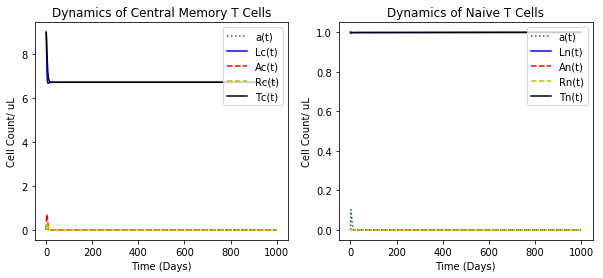

In [109]:
# plot results 
fig, ax = plt.subplots(figsize = (10,4), sharey = True)
plt.subplot(121)
plt.title('Dynamics of Central Memory T Cells')
plt.plot(t,a,'g:',label='a(t)')
plt.plot(t,Lc,'b-',label='Lc(t)')
plt.plot(t,Ac,'r--',label='Ac(t)')
plt.plot(t,Rc,'y--',label='Rc(t)')
plt.plot(t,Tc,'k-', label='Tc(t)')
#plt.plot(t,V,'g--',label = 'V(t)')


plt.ylabel('Cell Count/ uL')
plt.xlabel('Time (Days)')
plt.legend(loc='upper right')


#plt.yscale('symlog')

plt.subplot(122)
plt.title('Dynamics of Naive T Cells')
plt.plot(t,a,'g:',label='a(t)')
plt.plot(t,Ln,'b-',label='Ln(t)')
plt.plot(t,An,'r--',label='An(t)')
plt.plot(t,Rn,'y--',label='Rn(t)')
plt.plot(t,Tn,'k-', label='Tn(t)')
#plt.plot(t,V,'g--',label = 'V(t)')


plt.ylabel('Cell Count/ uL')
plt.xlabel('Time (Days)')
plt.legend(loc='upper right')

#plt.xlim([0,50])
#plt.yscale('symlog')

plt.show()


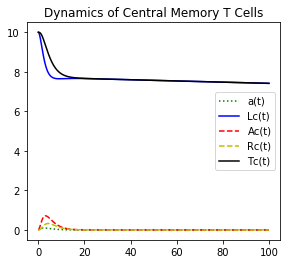

In [54]:
fig, ax = plt.subplots(figsize = (10,4), sharey = True)
plt.subplot(121)
plt.title('Dynamics of Central Memory T Cells')
plt.plot(t,a,'g:',label='a(t)')
plt.plot(t,Lc+Ln,'b-',label='Lc(t)')
plt.plot(t,Ac+An,'r--',label='Ac(t)')
plt.plot(t,Rc+Rn,'y--',label='Rc(t)')
plt.plot(t,Tc+Tn,'k-', label='Tc(t)')
#plt.plot(t,V,'g--',label = 'V(t)')
#plt.yscale('symlog')
plt.legend()

# Plot for a continous dosage

In [58]:
#initial conditions, there are three
z0 = [5,0,0,
      9,0,0,
      1,0,0,
      0
     ]

#number of time points
tn = 501

#time points
t = np.linspace(0,50, tn)


#store solutions
#Drug Doses
I = np.empty_like(t)
B = np.empty_like(t)
a = np.empty_like(t)

#Tcm cells
Lc = np.empty_like(t)
Ac = np.empty_like(t)
Rc = np.empty_like(t)
Tc = np.empty_like(t)

#Tn cells
Ln = np.empty_like(t)
An = np.empty_like(t)
Rn = np.empty_like(t)
Tn = np.empty_like(t)

#Virion
V = np.empty_like(t)


#record intial

I[0] = z0[0]
B[0] = z0[1]
a[0] = z0[2]

Lc[0] = z0[3]
Ac[0] = z0[4]
Rc[0] = z0[5]

Ln[0] = z0[6]
An[0] = z0[7]
Rn[0] = z0[8]

V[0] = z0[9]

Tc[0] = Lc[0]+Ac[0]+Rc[0]
Tn[0] = Ln[0]+An[0]+Rn[0]

#Constants for Tcm
con = 10**0
d_c = 0.006 * con
n_c = 0.0017* con
p_c = 0.0072* con
delta_c = 0.5*con
gamma_c = 0.5*con
w_c = 1
ld_c = 250

#Constants for Tn
d_n = 0.0000009 * con
n_n = 0 #0.005* con
p_n = 0.0002* con
delta_n = 0.1*con
gamma_n = 10*con
w_n = 10
ld_n = 300


#Constants for Viruse
dv = .5

#constants for the drugs
k = 0.4
e = 0.5

z1 = np.zeros(10)
z1[0] = 2
#Solve the ODE
for i in range(1,tn):

    tspan = [t[i-1],t[i]]
    if i < 200:
        if i%20 == 0:
            z0= z0+z1
        
    # solve for next step
    z = odeint(model,z0,tspan)
    # store solution for plotting
        
    I[i] = z[1][0]
    B[i] = z[1][1]
    a[i] = z[1][2]
    
    Lc[i] = z[1][3]
    Ac[i] = z[1][4]
    Rc[i] = z[1][5]

    Ln[i] = z[1][6]
    An[i] = z[1][7]
    Rn[i] = z[1][8]
    
    V[i] = z[1][9]
        
    Tc[i] = Lc[i]+Ac[i]+Rc[i]
    Tn[i] = Ln[i]+An[i]+Rn[i]
    # next initial condition
    z0 = z[1] 



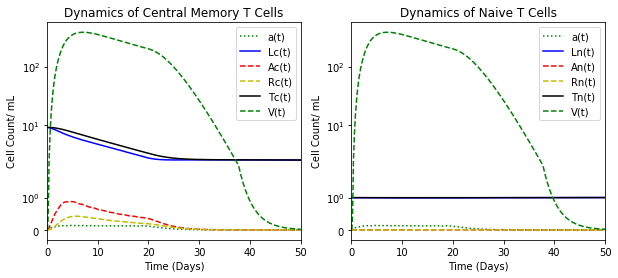

In [59]:
# plot results 
fig, ax = plt.subplots(figsize = (10,4), sharey = True)
plt.subplot(121)
plt.title('Dynamics of Central Memory T Cells')
plt.plot(t,a,'g:',label='a(t)')
plt.plot(t,Lc,'b-',label='Lc(t)')
plt.plot(t,Ac,'r--',label='Ac(t)')
plt.plot(t,Rc,'y--',label='Rc(t)')
plt.plot(t,Tc,'k-', label='Tc(t)')
plt.plot(t,V,'g--',label = 'V(t)')


plt.ylabel('Cell Count/ mL')
plt.xlabel('Time (Days)')
plt.legend(loc='upper right')

plt.xlim([0,50])
plt.yscale('symlog')

plt.subplot(122)
plt.title('Dynamics of Naive T Cells')
plt.plot(t,a,'g:',label='a(t)')
plt.plot(t,Ln,'b-',label='Ln(t)')
plt.plot(t,An,'r--',label='An(t)')
plt.plot(t,Rn,'y--',label='Rn(t)')
plt.plot(t,Tn,'k-', label='Tn(t)')
plt.plot(t,V,'g--',label = 'V(t)')


plt.ylabel('Cell Count/ mL')
plt.xlabel('Time (Days)')
plt.legend(loc='upper right')

plt.xlim([0,50])
plt.yscale('symlog')

plt.show()


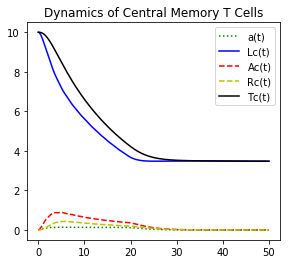

In [60]:
fig, ax = plt.subplots(figsize = (10,4), sharey = True)
plt.subplot(121)
plt.title('Dynamics of Central Memory T Cells')
plt.plot(t,a,'g:',label='a(t)')
plt.plot(t,Lc+Ln,'b-',label='Lc(t)')
plt.plot(t,Ac+An,'r--',label='Ac(t)')
plt.plot(t,Rc+Rn,'y--',label='Rc(t)')
plt.plot(t,Tc+Tn,'k-', label='Tc(t)')
#plt.plot(t,V,'g--',label = 'V(t)')
#plt.yscale('symlog')
plt.legend()